In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from glob import glob
from scipy.signal import resample,savgol_filter
import math
from numpy.fft import * 

In [2]:
datadir = "/home/doshna/Documents/PHD/data/fatties/"
stims = glob(datadir+"*/*.csv")

In [3]:
def for_range(signal, fs,freq_range):
    N = len(signal)
    fr = fftfreq(N,1/fs)
    fft_sig = fft(signal)

    freq_indices = np.where((fr >= freq_range[0]) & (fr <= freq_range[1]))

    fft_range = np.abs(fft_sig[freq_indices])
    freq_range = fr[freq_indices]

    return(fft_range,freq_range)

In [4]:
freqs = np.array([0.2000,0.3000,0.5000,0.7000,1.100,1.300,1.700,1.900,2.300,2.900,3.700,4.300,5.300,6.100,7.900,8.900,11.30,13.70,16.70 ,19.90]
)

Okay lets look at the DLT tracked flower position

In [4]:
d = pd.read_csv("DLTdv8_data_000_0xypts.csv")
x = d["pt1_cam1_X"]

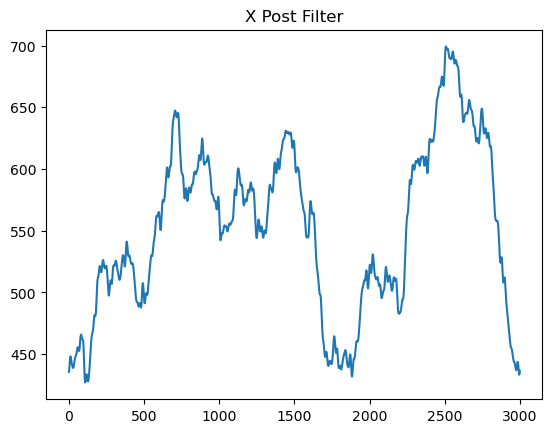

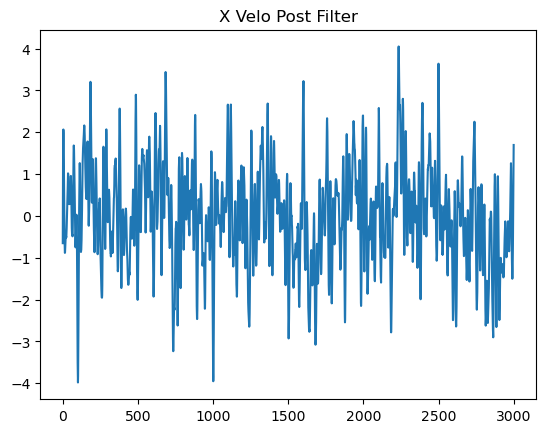

In [5]:
sgx = savgol_filter(x,21,5)
plt.plot(sgx)
plt.title("X Post Filter")
plt.show()
sgxv = savgol_filter(x,21,5,deriv=1)
plt.plot(sgxv)
plt.title("X Velo Post Filter")
plt.show()

In [6]:
sgxm,sgxf = for_range(sgx,300,[0,20])
sgxm = sgxm[1:] /np.max(sgxm[1:])
sgxf = sgxf[1:]

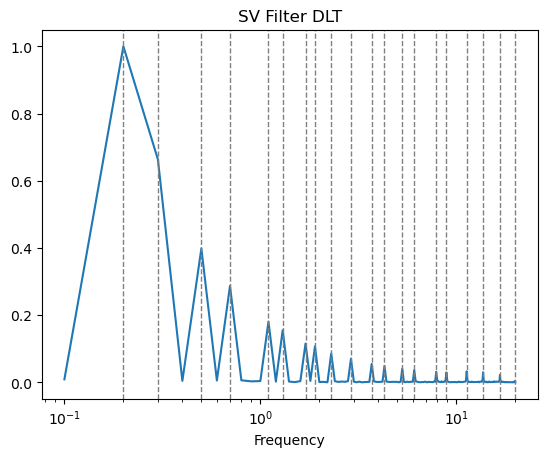

In [8]:
plt.semilogx(sgxf,sgxm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("SV Filter DLT")
plt.xlabel("Frequency")
plt.savefig("SVDLT.png")
plt.show()

Lets Look at Veloctity

In [9]:
sgxvm,sgxvf = for_range(sgxv,300,[0,20])
sgxvm = sgxvm[1:] /np.max(sgxvm[1:])
sgxvf = sgxvf[1:]

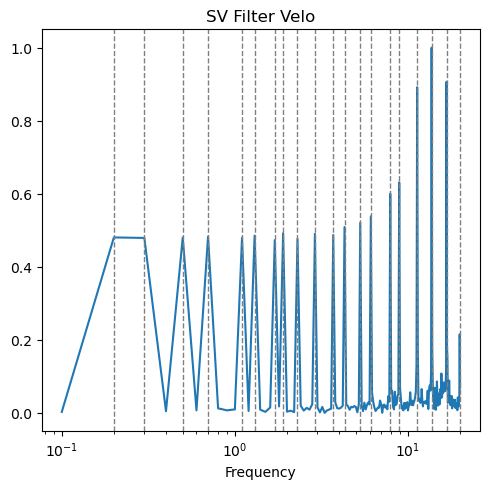

In [10]:
plt.figure(figsize=(5,5))
plt.semilogx(sgxvf,sgxvm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("SV Filter Velo")
plt.xlabel("Frequency")
plt.tight_layout()
plt.savefig("SVVeloDLT.png")
plt.show()

Lets make a big figure

In [15]:
t = np.linspace(0,10,3000)

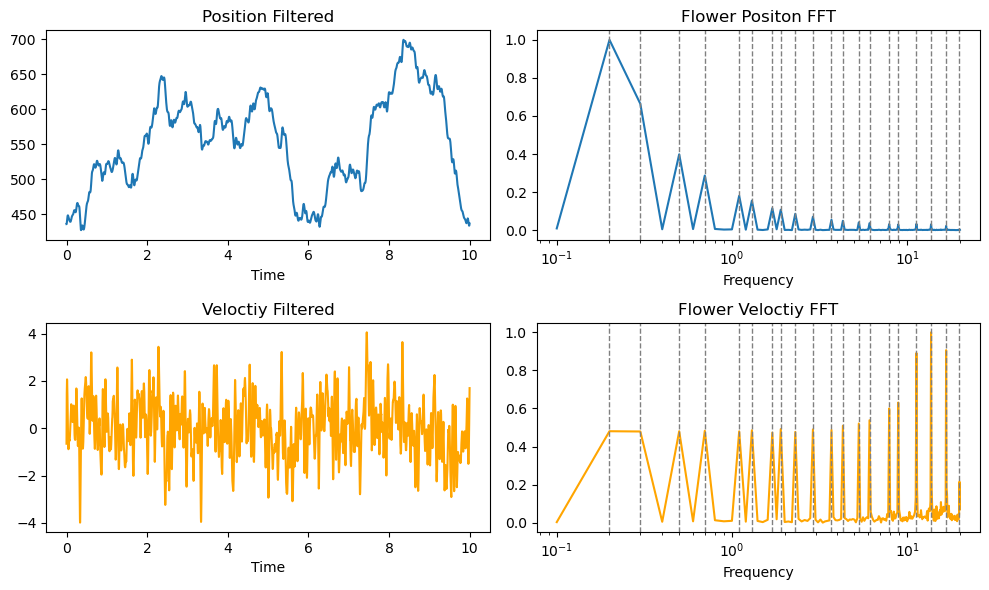

In [25]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(t,sgx)
plt.title("Position Filtered")
plt.xlabel("Time")
plt.subplot(223)
plt.plot(t,sgxv,color="orange")
plt.title("Veloctiy Filtered")
plt.xlabel("Time")

plt.subplot(222)
plt.semilogx(sgxf,sgxm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("Flower Positon FFT")
plt.xlabel("Frequency")

plt.subplot(224)
plt.semilogx(sgxvf,sgxvm,color="orange")
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("Flower Veloctiy FFT")
plt.xlabel("Frequency")

plt.tight_layout()
plt.savefig("posandveloandfft.png",bbox_inches="tight")
plt.show()


Lets Work on now combining multiple videos

In [15]:
trial_0 = glob(datadir+"2024_08_01/DLT_data/000/*.csv")

trials = {}
for t in trial_0:
    n = int(t.split("/")[-1].split("_")[-1][:2])
    trials[n] = np.array(pd.read_csv(t)["pt1_cam1_X"])

In [2]:
def mung_trial_data(path,savgol_params=[21,5],fs=300):
    paths = glob(path+"*.csv")
    trials = {}
    for p in paths:
        n = int(p.split("/")[-1].split("_")[-1][:2])
        trials[n] = np.array(pd.read_csv(p)["pt1_cam1_X"])

    full_x = np.concatenate([trials[k] for k in sorted(trials.keys())])
    full_x_filt = savgol_filter(full_x,savgol_params[0],savgol_params[1])
    full_x_filt_velo = savgol_filter(full_x,savgol_params[0],savgol_params[1],deriv=1)
    time = np.linspace(0,len(full_x)/fs,len(full_x))

    df = pd.DataFrame({"time": time, "raw": full_x, "filtered": full_x_filt, "velo": full_x_filt_velo})

    return(df)

In [3]:
datadir ="/home/doshna/Documents/PHD/data/fatties/2024_08_16/DLT_data/"
paths = glob(datadir+"*/")
for p in paths:
    n = p.split("/")[-2]
    m = p.split("/")[-4]
    d = mung_trial_data(p)
    d.to_csv(datadir+f"munged_stim_{m}_{n}.csv",index=False)


In [6]:
paths

['/home/doshna/Documents/PHD/data/fatties/2024_08_12/DLT_data/000/',
 '/home/doshna/Documents/PHD/data/fatties/2024_08_12/DLT_data/002/',
 '/home/doshna/Documents/PHD/data/fatties/2024_08_12/DLT_data/001/']

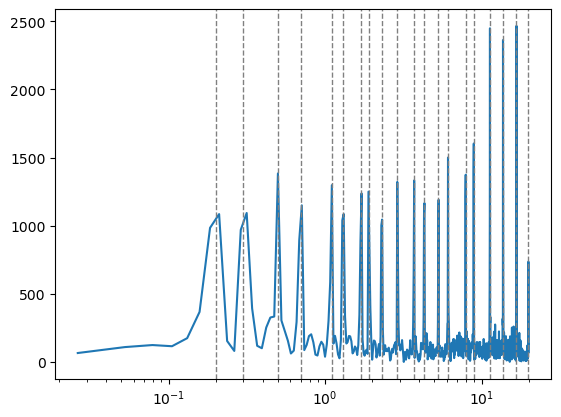

In [52]:
sig = np.array(d["velo"])
m,f = for_range(sig,300,[0,20])

plt.semilogx(f[1:],m[1:])
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.show()


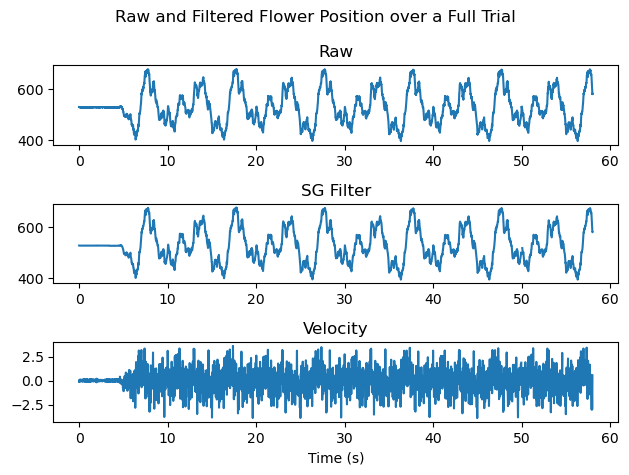

In [43]:
plt.figure()
plt.subplot(311)
plt.plot(time,full_x)
plt.title("Raw")
plt.subplot(312)
plt.plot(time,full_x_filt)
plt.title("SG Filter")
plt.subplot(313)
plt.plot(time,full_x_filt_velo)
plt.title("Velocity")
plt.xlabel("Time (s)")

plt.suptitle("Raw and Filtered Flower Position over a Full Trial")
plt.tight_layout()
plt.savefig("example_full_Trial_stim.png",bbox_inches="tight")
plt.show()